## 9 - Which player has won the most tournaments in a single month? 

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

event_files = glob('../data/raw/*/event_[0-9]*.parquet')
home_files = glob('../data/raw/*/home_team_[0-9]*.parquet')
away_files = glob('../data/raw/*/away_team_[0-9]*.parquet')

In [2]:
def extract_month(file_path):
    """
    Extracts the month from files with the parent folder name format 'YYYYMMDD'.
    """
    folder_name = os.path.basename(os.path.dirname(file_path))
    return f"{folder_name[:4]}-{folder_name[4:6]}"

In [3]:
# Load events with month
df_events = pd.concat([pd.read_parquet(f, columns=['match_id', 'winner_code']).assign(month=extract_month(f)) for f in event_files])
df_events.head()

,match_id,winner_code,month
0,12075272,2,2024-02
0,12076290,1,2024-02
0,12077080,1,2024-02
0,12077399,2,2024-02
0,12076858,1,2024-02


In [4]:
# Load home teams data
df_home = pd.concat([pd.read_parquet(f, columns=['match_id', 'full_name']) for f in home_files])
df_home = df_home.rename(columns={'full_name': 'home_player'})

# Load away teams data
df_away = pd.concat([pd.read_parquet(f, columns=['match_id', 'full_name']) for f in away_files])
df_away = df_away.rename(columns={'full_name': 'away_player'})

In [5]:
# Merge all data together
dfs = df_events.merge(df_home, on='match_id').merge(df_away, on='match_id')
dfs.head()

,match_id,winner_code,month,home_player,away_player
0,12075272,2,2024-02,"Darderi, Luciano","Cerundolo, Juan Manuel"
1,12075272,2,2024-02,"Darderi, Luciano","Cerundolo, Juan Manuel"
2,12075272,2,2024-02,"Darderi, Luciano","Cerundolo, Juan Manuel"
3,12075272,2,2024-02,"Darderi, Luciano","Cerundolo, Juan Manuel"
4,12077080,1,2024-02,"Hibino, Nao","Linette, Magda"


In [6]:
# Merge data
dfs['winning_player'] = dfs.apply(lambda x: x['home_player'] if x['winner_code'] == 1 else x['away_player'],axis=1)

# Drop duplicate match_id rows && NaN
dfs = dfs.drop_duplicates(subset='match_id').dropna()
dfs.head()

,match_id,winner_code,month,home_player,away_player,winning_player
0,12075272,2,2024-02,"Darderi, Luciano","Cerundolo, Juan Manuel","Cerundolo, Juan Manuel"
4,12077080,1,2024-02,"Hibino, Nao","Linette, Magda","Hibino, Nao"
12,12077281,2,2024-02,"Rehberg, Max Hans","Agwi, Michael","Agwi, Michael"
21,12075955,1,2024-02,"Watanuki, Yosuke","Rubio Fierros, Alan Fernando","Watanuki, Yosuke"
25,12049571,2,2024-02,"Jarry, Nicolas","Díaz Acosta, Facundo","Díaz Acosta, Facundo"


In [7]:
# Counting winns
monthly_win_counts = (
    dfs.groupby(['month', 'winning_player'])
    .size()
    .reset_index(name='win_count')
)
monthly_win_counts.head()

,month,winning_player,win_count
0,2024-02,"Abbagnato, Anastasia",2
1,2024-02,"Adams, Harrison",1
2,2024-02,"Added, Dan",3
3,2024-02,"Adkar, Vaishnavi",2
4,2024-02,"Agafonov, Egor",3


In [8]:
# Map month numbers to month names
month_map = {
    '01': 'January', '02': 'February', '03': 'March', 
    '04': 'April',   '05': 'May',      '06': 'June', 
    '07': 'July',    '08': 'August',   '09': 'September', 
    '10': 'October', '11': 'November', '12': 'December'
}

In [9]:
# Sort monthly_win_counts by month and descending win_count
monthly_win_counts_sorted = monthly_win_counts.sort_values(['month', 'win_count'], ascending=[True, False])

# Group by month and take top 3 winners per month
top3_monthly_winners = monthly_win_counts_sorted.groupby('month').head(3).reset_index(drop=True)

# Extract the MM part and map to month name
top3_monthly_winners['month_name'] = top3_monthly_winners['month'].apply(lambda x: month_map[x[5:7]] + ' ' + x[:4])

top3_monthly_winners[['month_name', 'winning_player', 'win_count']]

,month_name,winning_player,win_count
0,February 2024,"Popko, Dmitry",15
1,February 2024,"Gengel, Marek",14
2,February 2024,"Kužmová, Katarína",14
3,March 2024,"Faria, Jaime",14
4,March 2024,"Soriano Barrera, Adria",14
5,March 2024,"Estable, Julieta",13


In [10]:
# Most tournaments in a single month
max_wins = monthly_win_counts.groupby('month')['win_count'].transform('max')

# Filter to keep only rows where win_count equals the maximum for that month
top_monthly_winners = monthly_win_counts[monthly_win_counts['win_count'] == max_wins]

# Sort the results
top_monthly_winners = top_monthly_winners.sort_values(['month', 'winning_player'])

print(f"\nPlayers with most wins per month is: {top_monthly_winners.iloc[0]}")



Players with most wins per month is: month                   2024-02
winning_player    Popko, Dmitry
win_count                    15
Name: 1029, dtype: object


In [11]:
# Total matches in March 2024
total_mar_matches = dfs[dfs['month'] == '2024-03']['match_id'].nunique()

# Calculate win percentages for top players
faria_wins = 14
soriano_wins = 14
estable_wins = 13

faria_pct = (faria_wins / total_mar_matches) * 100
soriano_pct = (soriano_wins / total_mar_matches) * 100
estable_pct = (estable_wins / total_mar_matches) * 100

print(f"Total matches in Mar 2024: {total_mar_matches}")
print(f"Faria's win percentage: {faria_pct:.2f}%")
print(f"Soriano Barrera's win percentage: {soriano_pct:.2f}%")
print(f"Estable's win percentage: {estable_pct:.2f}%")


Total matches in Mar 2024: 4794
Faria's win percentage: 0.29%
Soriano Barrera's win percentage: 0.29%
Estable's win percentage: 0.27%


In [12]:
# Total number of matches in February 2024
total_feb_matches = dfs[dfs['month'] == '2024-02']['match_id'].nunique()

# Calculate Popko's win percentage
popko_wins = 15
popko_win_pct = (popko_wins / total_feb_matches) * 100

print(f"Total matches in Feb 2024: {total_feb_matches}")
print(f"Popko's win percentage: {popko_win_pct:.2f}%")

Total matches in Feb 2024: 4530
Popko's win percentage: 0.33%


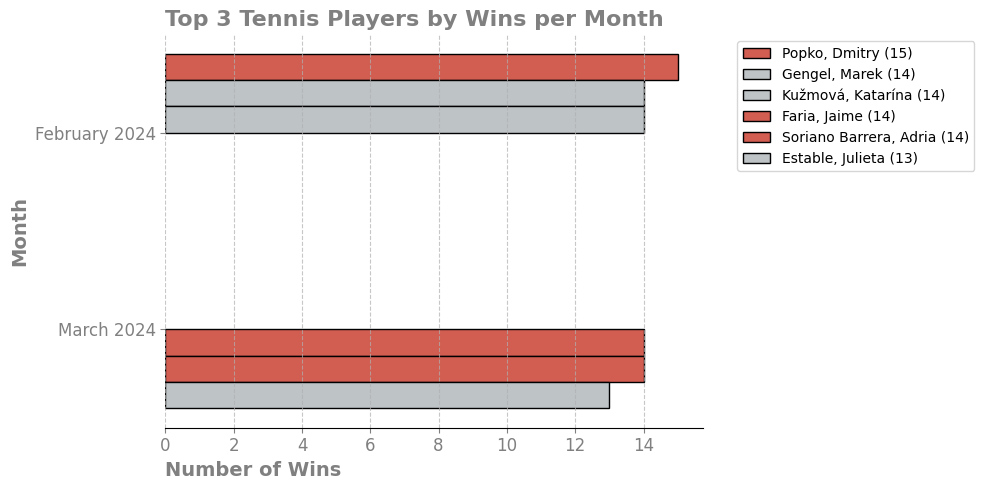

In [13]:
# Assign highlight for color mapping
max_wins_per_month = top3_monthly_winners.groupby('month')['win_count'].transform('max')
top3_monthly_winners['highlight'] = np.where(top3_monthly_winners['win_count'] == max_wins_per_month, 'Top', 'Other')

palette = {'Top': '#e74c3c', 'Other': '#bdc3c7'}

# Map player colors
player_colors = {}
for player in top3_monthly_winners['winning_player']:
    if (top3_monthly_winners[(top3_monthly_winners['winning_player'] == player) & (top3_monthly_winners['highlight'] == 'Top')].shape[0] > 0):
        player_colors[player] = palette['Top']
    else:
        player_colors[player] = palette['Other']

# Visualization
plt.figure(figsize=(10, 5))

ax = sns.barplot(
    data=top3_monthly_winners,
    y='month_name',
    x='win_count',
    hue='winning_player',
    palette=player_colors,
    dodge=True,
    edgecolor='black'
)

for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

ax.grid(axis='x', linestyle='dashed', alpha=0.7)
ax.set_title("Top 3 Tennis Players by Wins per Month", loc='left', weight='bold', fontsize=16, color='gray')
ax.set_xlabel("Number of Wins", weight='bold', fontsize=14, color='gray', loc='left')
ax.set_ylabel("Month", weight='bold', fontsize=14, color='gray')
ax.tick_params(axis='x', colors='gray', labelsize=12)
ax.tick_params(axis='y', colors='gray', labelsize=12)

# Create new labels with win counts appended
total_wins = top3_monthly_winners.groupby('winning_player')['win_count'].sum()
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
    if label in total_wins:
        new_labels.append(f"{label} ({total_wins[label]})")
    else:
        new_labels.append(label)

# Set legend with updated labels
ax.legend(handles, new_labels, title='', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplots_adjust(left=0.25)
plt.tight_layout()
plt.savefig('../data/output/figures/img9.png')
plt.show()
